In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os
import tarfile
import shutil
from PIL import *


In [6]:
DIR= r'C:\Users\Md Moradul Siddique\Documents\data\Money data'

SRC = DIR + '\validation'
DST = DIR + '\\testing'

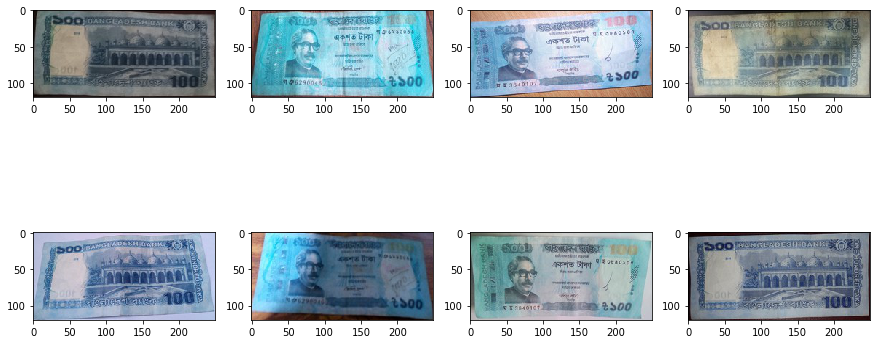

In [7]:
img_path_100 = DIR + '/training/100'
img_names = os.listdir(img_path_100)
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(2):
  for j in range(4):
    img_name = random.choice(img_names)
    img = plt.imread(img_path_100 + '/' + img_name)
    ax[i][j].imshow(img)

In [10]:
TRAINING_DATA_PATH = DIR + '\\training'
IMG_SIZE = (250, 500)
NUM_CLASSES = 9
VALID_DATA_DIR = DIR + '\\validation'
BATCH_SIZE = 6
NUM_EPOCH = 12
FREEZE_LAYERS = 16 
LEARNING_RATE = 0.0002
DROP_OUT = .2

In [11]:
model = Xception(include_top = False,
              weights = 'imagenet',
              input_tensor = None,
              input_shape = (250, 500, 3))

83689472/83683744 [==============================] - 10s 0us/step


In [12]:
top_layer = model.output
x = GlobalAveragePooling2D()(top_layer)
op = Dense(NUM_CLASSES, activation = 'softmax', name = 'softmax')(x)
model_final = Model(inputs = model.input, outputs = op)

In [13]:
for layer in model_final.layers[:FREEZE_LAYERS]:
  layer.trainable = False

for layer in model_final.layers[FREEZE_LAYERS:]:
  layer.trainable = True

In [14]:
model_final.compile(optimizer = Adam(lr = LEARNING_RATE),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [15]:
print(model_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 249, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 249, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [16]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [17]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [18]:
train_batches = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 1637 images belonging to 9 classes.


In [19]:

valid_batches = train_datagen.flow_from_directory(VALID_DATA_DIR,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 456 images belonging to 9 classes.


In [20]:

class_dictionary = train_batches.class_indices
class_dictionary

{'1': 0,
 '10': 1,
 '100': 2,
 '1000': 3,
 '2': 4,
 '20': 5,
 '5': 6,
 '50': 7,
 '500': 8}

In [21]:
checkpoint = ModelCheckpoint('Xception_model.h5', monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, save_weights_only = False,
                             mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10,
                      verbose = 1, mode = 'auto')

In [22]:
history=model_final.fit_generator(train_batches,
                          steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                          validation_data = valid_batches,
                          validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                          epochs = NUM_EPOCH,
                          callbacks = [checkpoint, early])

C:\Users\Md Moradul Siddique\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
46/46 [==============================] - 429s 9s/step - loss: 2.0006 - accuracy: 0.2686 - val_loss: 1.2253 - val_accuracy: 0.7692

Epoch 00001: val_accuracy improved from -inf to 0.76923, saving model to Xception_model.h5
Epoch 2/12
46/46 [==============================] - 430s 9s/step - loss: 0.8919 - accuracy: 0.7636 - val_loss: 0.3599 - val_accuracy: 0.8974

Epoch 00002: val_accuracy improved from 0.76923 to 0.89744, saving model to Xception_model.h5
Epoch 3/12
46/46 [==============================] - 395s 9s/step - loss: 0.4944 - accuracy: 0.8638 - val_loss: 0.2570 - val_accuracy: 0.9359

Epoch 00003: val_accuracy improved from 0.89744 to 0.93590, saving model to Xception_model.h5
Epoch 4/12
46/46 [==============================] - 366s 8s/step - loss: 0.3569 - accuracy: 0.8783 - val_loss: 0.1140 - val_accuracy: 0.9744

Epoch 00004: val_accuracy improved from 0.93590 to 0.97436, saving model to Xception_model.h5
Epoch 5/12
46/46 [==============================] - 350s 8s

In [23]:
test_categories = os.listdir(DIR + '/testing')

In [24]:
class_dictionary

{'1': 0,
 '10': 1,
 '100': 2,
 '1000': 3,
 '2': 4,
 '20': 5,
 '5': 6,
 '50': 7,
 '500': 8}

In [25]:
vals = list(class_dictionary.values())
keys = list(class_dictionary.keys())

In [26]:
vals

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [27]:
keys

['1', '10', '100', '1000', '2', '20', '5', '50', '500']

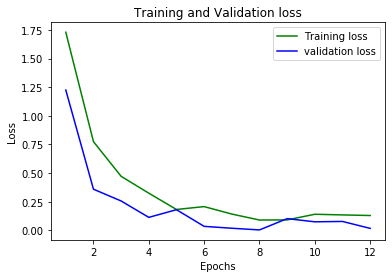

In [28]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

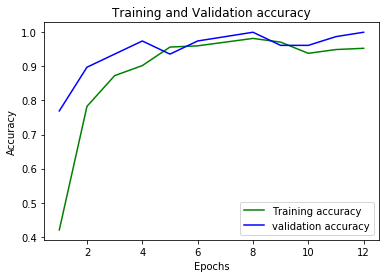

In [29]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predicting on Test dataset

save the model

In [30]:
from tensorflow.keras.models import load_model

model_final.save('bd_money_Classifier_Xception.h5')

Load the model

In [33]:

from tensorflow.keras.preprocessing import image

In [50]:
model=load_model('bd_money_Classifier_Xception.h5')